# GIS module

GIS operations are integral to hydrology processes. This page demonstrates how to use xhydro to perform GIS manipulations such as delineating watershed boundaries and extracting physiographic, climatological and geographical variables at the watershed scale.

In [1]:
import geopandas as gpd
import pandas as pd
import warnings
import leafmap
import numpy as np
import xarray as xr

from pathlib import Path
from IPython.core.display import HTML, display

import xdatasets as xd
import xhydro.gis as xhgis
from xhydro.indicators import get_yearly_op

## Watershed delineation

The [leafmap](https://leafmap.org/) library is employed for generating interactive maps. This map serves the purpose of selecting pour points or visualizing the resulting watershed boundaries. Although utilizing the map is not essential for conducting the calculations, it proves useful for visualization purposes.

In [2]:
m = leafmap.Map(center=(48.63, -74.71), 
                zoom=5,
                basemap="USGS Hydrography")

### a) From a list of coordinates
In this scenario, we select two pour points, with each one representing the outlet for the watersheds of Lac Saint-Jean and the Ottawa River, respectively.

In [3]:
lng_lat = [(-69.81971, 48.14720), # Lac Saint-Jean watershed
           (-74.393438, 45.572442) # Ottawa river watershed
          ]

### b) From markers on a map

Instead of using a list, a more interactive approach is to directly select pour points from the existing map `m`. The following image illustrates the process of selecting pour points by dragging markers to the desired locations on the map.

![test](../../docs/_static/_images/example_draw_marker,png)

The next cell is only useful for the documentation as it simulates a user selecting a pour point from the map `m`. You should instead remove this code and interact with the map in object `m` as shown above by positionning markers at sites of interest

In [4]:
m.draw_features = [{'type': 'Feature',
  'properties': {},
  'geometry': {'type': 'Point', 'coordinates': [-73.118597, 46.042467]}}] # Richelieu watershed

After selecting points using either approach a) or b), or a combination of both, we can initiate the watershed delineation calculation.

In [5]:
gdf = xhgis.watershed_delineation(coordinates=lng_lat, 
                                  map=m)
gdf

,HYBAS_ID,Upstream Area (sq. km).,geometry,category,color
0,7120034330,87595.8,"POLYGON ((-74.37864 48.88141, -74.37452 48.886...",3,#41b6c4
1,7120398781,144026.8,"POLYGON ((-80.07991 46.77860, -80.08529 46.782...",5,#081d58
2,7120382860,23717.7,"POLYGON ((-73.77437 43.36757, -73.77557 43.388...",1,#ffffd9


The outcomes are stored in a `gpd.GeoDataFrame` object, allowing us to save our polygons in various common formats such as shapefile or geojson. If a map `m` is present, the polygons will automatically be added to it. If you want to vizualize the map, simply type `m` in the code cell to render it. If displaying the map directly is not compatible with your notebook interpreter, you can utilize the following code to extract the HTML from the map and plot it:

In [6]:
m.zoom_to_gdf(gdf)
display(HTML(m.to_html()))

### c) From [xdatasets](https://github.com/hydrologie/xdatasets)
Automatically delineating watershed boundaries is a valuable tool in the toolbox, but users are encouraged to utilize official watershed boundaries if they already exist, instead of creating new ones. This functionality fetches a list of basins from [xdatasets](https://github.com/hydrologie/xdatasets)' supported datasets, and upon request, [xdatasets](https://github.com/hydrologie/xdatasets) provides a `gpd.GeoDataFrame` containing the precalculated boundaries for these basins. Currently, the following watershed sources are available as of today.:

| Source                                                                                                                                                             | Dataset name   |
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| [DEH](https://www.cehq.gouv.qc.ca/atlas-hydroclimatique/stations-hydrometriques/index.htm)                                                                         | deh_polygons   |
| [HYDAT](https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/national-archive-hydat.html) | hydat_polygons |
| [HQ](https://www.hydroquebec.com/r)                                                                                                                                | hq_polygons    |


In [7]:
gdf = xd.Query(
    **{
        "datasets": {
            "deh_polygons": {
                "id": ["031*","0421*"],
                "regulated": ["Natural"],
            }
        }
    }
).data.reset_index()

gdf

,Station,Superficie,geometry
0,031501,21.868620,"POLYGON ((-72.47379 46.23340, -72.46888 46.228..."
1,031502,15.708960,"POLYGON ((-72.50127 46.21216, -72.50086 46.213..."
2,042103,579.479614,"POLYGON ((-78.49014 46.64514, -78.49010 46.645..."


## Extract watershed properties

After obtaining our watershed boundaries, we can extract valuable properties such as geographical information, land use classification and climatological data from the delineated watersheds.

### a) Geographical watershed properties
Initially, we extract geographical properties of the watershed, including the perimeter, total area, Gravelius coefficient and basin centroid. It's important to note that this function returns all the columns present in the provided `gpd.GeoDataFrame` argument.

In [8]:
xhgis.watershed_properties(gdf)

,Station,Superficie,area,perimeter,gravelius,centroid
0,031501,21.868620,2.186862e+07,27186.996845,1.640007,"(-72.48631199105834, 46.22277542928622)"
1,031502,15.708960,1.570896e+07,20263.293021,1.442220,"(-72.47966677792694, 46.21359517038631)"
2,042103,579.479614,5.794796e+08,283765.058390,3.325331,"(-78.37036445281987, 46.48287117609677)"


For added convenience, we can also retrieve the same results in the form of an `xr.Dataset`:

In [9]:
xhgis.watershed_properties(gdf[['Station', 'geometry']],
                           unique_id='Station',
                           output_format='xarray')

<xarray.Dataset>
Dimensions:    (Station: 3)
Coordinates:
  * Station    (Station) object '031501' '031502' '042103'
Data variables:
    area       (Station) float64 2.187e+07 1.571e+07 5.795e+08
    perimeter  (Station) float64 2.719e+04 2.026e+04 2.838e+05
    gravelius  (Station) float64 1.64 1.442 3.325
    centroid   (Station) object (-72.48631199105834, 46.22277542928622) ... (...

### b) Land-use classification

In [10]:
df = xhgis.land_use_classification(gdf, 
                                   unique_id='Station')
df

  0%|          | 0/3 [00:00<?, ?it/s]

,pct_crops,pct_built_area,pct_trees,pct_rangeland,pct_water,pct_bare_ground,pct_flooded_vegetation,pct_snow/ice
Station,,,,,,,,
031501,0.776151,0.030159,0.191648,0.002042,0.000000,0.000000,0.000000,0.000000e+00
031502,0.755217,0.023085,0.218869,0.002830,0.000000,0.000000,0.000000,0.000000e+00
042103,0.000000,0.000101,0.863602,0.026126,0.109987,0.000021,0.000162,3.780111e-07


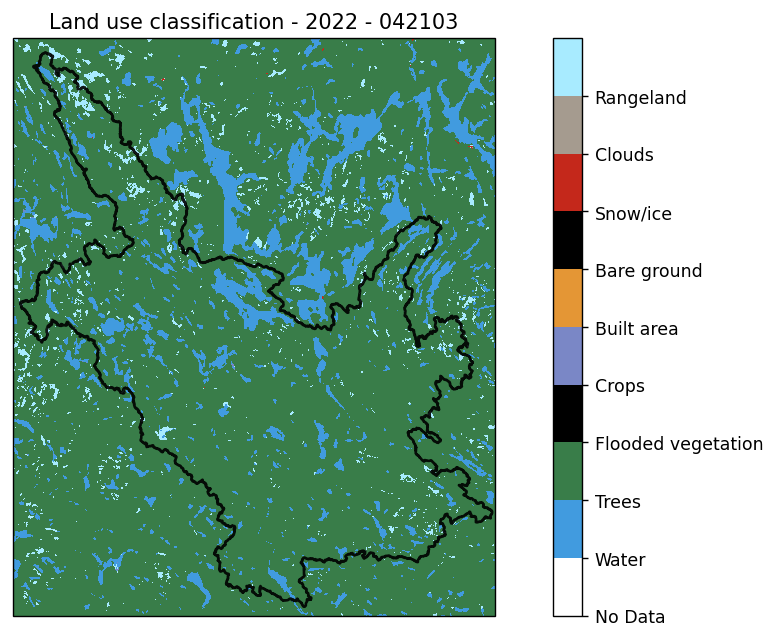

In [11]:
ax = xhgis.land_use_plot(gdf,
                         unique_id='Station',
                         idx=2)


### c) Climate indicators
The step of extracting climatic indicators is the most complex. Indeed, to accomplish this, access to a weather dataset for the various watersheds within our `gdf` object is required. Fortunately, `xdatasets` precisely facilitates such operations. Subsequently, the function `get_yearly_op`, built upon the `xclim` library, offers impressive flexibility in defining indicators tailored to the user's needs.

To initiate the process, we employ ERA5-Land reanalysis data spanning the period from 1981 to 2010 as our climatological dataset.

In [12]:
datasets = {
    "era5_land_reanalysis": {"variables": ["t2m", "tp", "sd"]},
}
space = {
    "clip": "polygon",  # bbox, point or polygon
    "averaging": True,
    "geometry": gdf,  # 3 polygons
    "unique_id": "Station",
}
time = {
    "start": "1981-01-01",
    "end": "2010-12-31",
    "timezone": "America/Montreal",
}

ds = xd.Query(datasets=datasets, space=space, time=time).data.squeeze()

0it [00:00, ?it/s]

Because the next few steps use [xclim](https://xclim.readthedocs.io/en/stable/index.html) under the hood, the dataset is required to be CF-compliant. At a minimum, the xarray.DataArray used has to follow these principles:

- The dataset needs a time dimension.
- If there is a spatial dimension, such as Station in the example below, it needs an attribute cf_role with timeseries_id as its value.
- The variable will at the very least need a units attribute, although other attributes such as long_name and cell_methods are also expected by xclim and warnings will be generated if they are missing.

The following code adds the missing attributes :

In [13]:
ds['tas'] = ds.t2m - 273.15 # We should also consider using xarray-pint/xclim to improve units conversion 
ds["tas"].attrs.update(ds.t2m.attrs)
ds["tas"].attrs.update({"units": "C", "cell_methods": "time: mean"})
ds["tp"].attrs.update({"cell_methods": "time: mean within days"})
ds["sd"].attrs.update({"units": "m", "cell_methods": "time: mean within days"})
ds

<xarray.Dataset>
Dimensions:  (time: 262968, Station: 3)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 ... 2010-12-31T23:00:00
  * Station  (Station) object '031501' '031502' '042103'
    source   <U20 'era5_land_reanalysis'
Data variables:
    t2m      (Station, time) float64 249.9 249.9 249.7 ... 275.6 275.5 275.5
    tp       (Station, time) float64 0.0 0.0 0.0 ... 3.698e-06 6.662e-07
    sd       (Station, time) float64 0.05507 0.05507 0.05507 ... 0.06421 0.06384
    tas      (Station, time) float64 -23.29 -23.28 -23.49 ... 2.455 2.389 2.339

In the second step, we can define seasons using indexers that are compatible with `xclim.core.calendar.select_time`. There are currently four accepted types of indexers:

- month, followed by a sequence of month numbers.

- season, followed by one or more of ‘DJF’, ‘MAM’, ‘JJA’ and ‘SON’.

- doy_bounds, followed by a sequence representing the inclusive bounds of the period to be considered (start, end).

- date_bounds, which is the same as above, but using a month-day (%m-%d) format.


Following this, we specify the operations we intend to calculate for each variable. The supported operations include "max," "min","mean" and "sum".

In [14]:
timeargs = {
    "01": {"month": [1]},
    "02": {"month": [2]},
    "03": {"month": [3]},
    "04": {"month": [4]},
    "05": {"month": [5]},
    "06": {"month": [6]},
    "07": {"month": [7]},
    "08": {"month": [8]},
    "09": {"month": [9]},
    "10": {"month": [10]},
    "11": {"month": [11]},
    "12": {"month": [12]},
    "spring": {"date_bounds": ["02-11", "06-19"]},
    "summer_fall": {"date_bounds": ["06-20", "11-19"]},
    "year": {"date_bounds": ["01-01", "12-31"]},
    }

operations = {
    "tas": ["max","mean", "min"],
    "tp": ["sum"], 
    "sd": ["mean"], 
}


The combination of `timeargs` and `operations` through the Cartesian product yields a rapid generation of an extensive array of climate indicators.

In [15]:
ds_climatology = xr.merge(
    [
        get_yearly_op(ds, input_var=variable, op=op, timeargs=timeargs)
        for (variable, ops) in operations.items() for op in ops
    ]
)
ds_climatology

<xarray.Dataset>
Dimensions:               (Station: 3, time: 30)
Coordinates:
  * Station               (Station) object '031501' '031502' '042103'
    source                <U20 'era5_land_reanalysis'
  * time                  (time) datetime64[ns] 1981-01-01 ... 2010-01-01
Data variables: (12/75)
    tas_max_01            (Station, time) float64 5.1 3.616 ... -4.901 3.161
    tas_max_02            (Station, time) float64 13.23 1.781 ... 4.389 3.544
    tas_max_03            (Station, time) float64 11.61 10.72 ... 8.564 12.78
    tas_max_04            (Station, time) float64 19.4 20.66 ... 24.34 25.98
    tas_max_05            (Station, time) float64 24.39 28.17 ... 24.25 32.24
    tas_max_06            (Station, time) float64 29.32 28.33 ... 30.66 25.42
    ...                    ...
    sd_mean_10            (Station, time) float64 0.0003611 ... 0.0004031
    sd_mean_11            (Station, time) float64 0.00429 0.002369 ... 0.007307
    sd_mean_12            (Station, time) float64 0.04407 0.005757 ... 0.05267
    sd_mean_spring        (Station, time) float64 0.006949 0.09208 ... 0.03331
    sd_mean_summer_fall   (Station, time) float64 0.0001345 ... 0.0007276
    sd_mean_year          (Station, time) float64 0.01436 0.04745 ... 0.02575
Attributes:
    cat:variable:          ('tas_max_01',)
    cat:xrfreq:            AS-JAN
    cat:frequency:         yr
    cat:processing_level:  indicators
    cat:id:

The same data can also be visualized as a `pd.DataFrame` as well : 

In [16]:
pd.set_option('display.max_rows', 100)
ds_climatology.mean('time').to_dataframe().T

Station,031501,031502,042103
source,era5_land_reanalysis,era5_land_reanalysis,era5_land_reanalysis
tas_max_01,5.79328,5.83979,3.640586
tas_max_02,5.709544,5.74949,4.044133
tas_max_03,12.451726,12.531728,10.525447
tas_max_04,21.224634,21.254693,19.973493
tas_max_05,26.618743,26.62262,25.819365
tas_max_06,29.915254,29.914234,28.824476
tas_max_07,30.538177,30.541674,29.448428
tas_max_08,29.401676,29.396607,28.537646
tas_max_09,26.409743,26.420074,25.724547
